In [88]:
import os

import numpy as np
import pandas as pd
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw

import tqdm.notebook as tqdm
from scipy.signal import periodogram

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils import *

In [189]:
# Path to the data folder in the repo
data_path = r'C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/2021-02-15_21-59-19_Or179_Or177_overnight'

# Path to the raw data in the hard drive
with open(os.path.join(data_path, 'LFP_location.txt')) as f:    
    OE_data_path = f.read()

In [191]:
# Whole recording from the hard drive
recording = se.BinDatRecordingExtractor(
    OE_data_path,
    30000,
    40, # Num channels
    dtype='int16',
)


### Get each bird's recording, and their microphone channels

In [192]:
# Note I am adding relevant ADC channels
# First bird
Or179_recording = se.SubRecordingExtractor(
    recording,
    channel_ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 32]
)

# Second bird
Or177_recording = se.SubRecordingExtractor(
    recording,
    channel_ids=[16, 17,18,19,20,21,22,23,24,25,26,27,28,29,30,31, 33]
)

### Check that the mic channels are online

[(-299999.95, 6299998.95, 17043.45, 18793.55),
 (-299999.95, 6299998.95, 16712.6, 19229.4)]

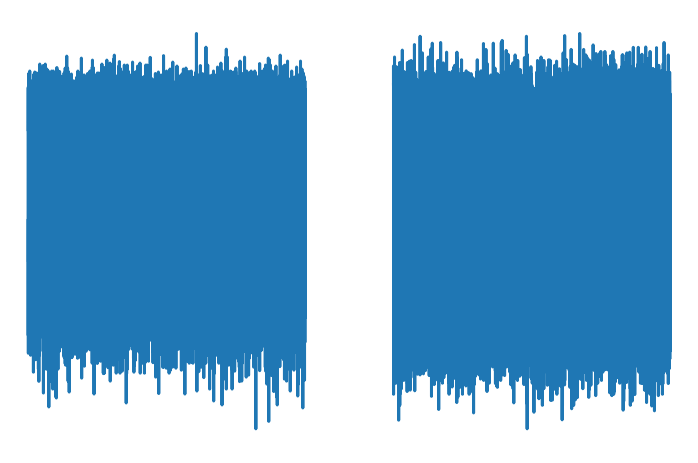

In [193]:
fig, ax = plt.subplots(1,2)
ax[0].plot(Or179_mic.get_traces(start_frame=600*30000, end_frame=800*30000).flatten())
ax[1].plot(Or177_mic.get_traces(start_frame=600*30000, end_frame=800*30000).flatten())

[axi.axis('off') for axi in ax]

Looks like they are online. Good to know.

### Let's try to align some songs

In [207]:
# Get wav files
wav_paths = [os.path.join(data_path,wav_file) 
             for wav_file in os.listdir(data_path) if wav_file.endswith('.wav')]

# Get tranges for wav files in the actual recording
# OE_data_path actually contains the path all the way to the .bin. We just need the parent directory
# with the timestamp.

# Split up the path
OE_data_path_split= OE_data_path.split(os.sep)

# Take only the first three. os.path is weird so we manually add the separator after the 
# drive name.
OE_parent_path = os.path.join(OE_data_path_split[0] + os.sep, *OE_data_path_split[1:3])

# Get all time ranges given the custom offset.
tranges=np.array([
    get_trange(OE_parent_path, path, offset=datetime.timedelta(minutes=5, seconds=42), duration=3) 
    for path in wav_paths])


In [208]:
wav_df = pd.DataFrame({'wav':wav_paths, 'trange0':tranges[:, 0], 'trange1':tranges[:, 1]})
wav_df.head()

wav  trange0  trange1
0  C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...  30152.5  30155.5
1  C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...  30159.5  30162.5
2  C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...  30165.5  30168.5
3  C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...  30169.5  30172.5
4  C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...  30172.5  30175.5

Connect the wav files to the recording

In [209]:
wav_file, OE_data_path

('C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/2021-02-15_21-59-19_Or179_Or177_overnight\\Or177_44243.22588532_2_16_6_16_28.wav',
 'D:\\D_Zs_Tetx\\2021-02-15_21-59-19_Or179_Or177_overnight\\Record Node 101\\experiment1\\recording1\\continuous\\Rhythm_FPGA-100.0\\continuous.dat')

30152.5 30155.5
30159.5 30162.5


C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self._trange[0], self._trange[1], l_xticks))


30165.5 30168.5
30169.5 30172.5


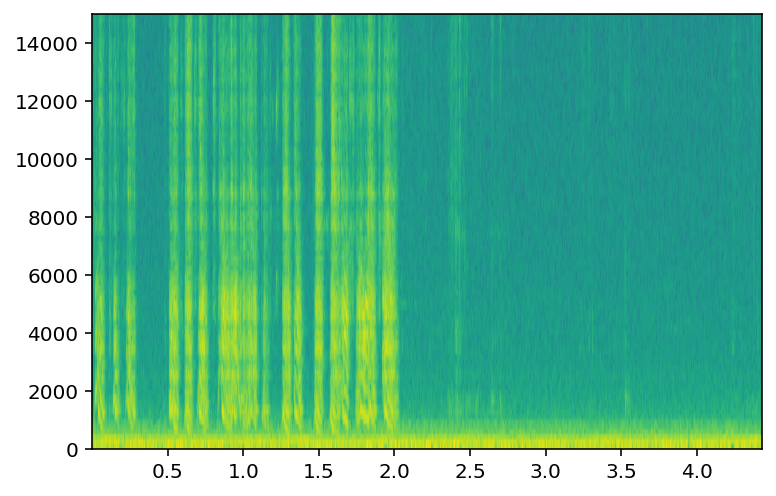

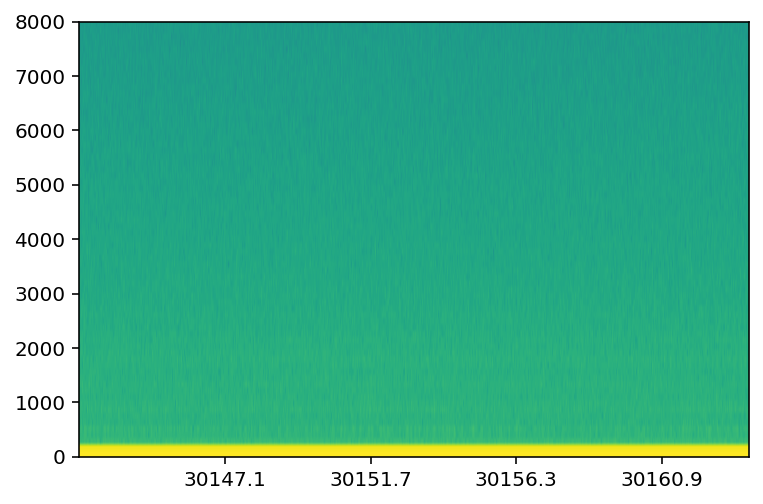

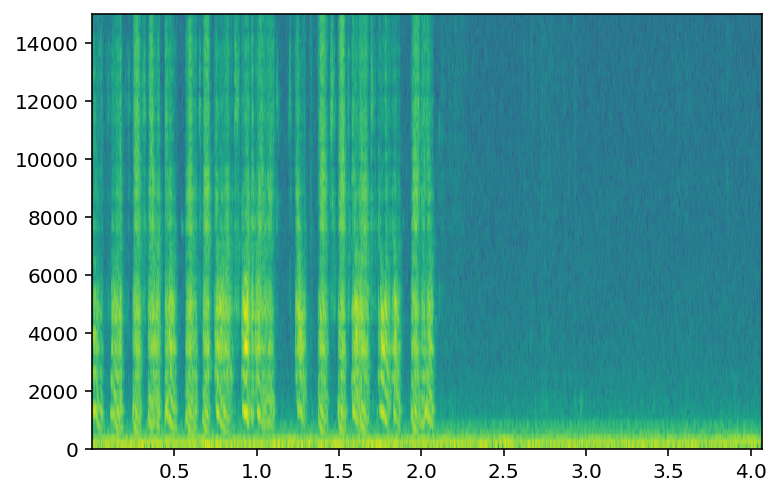

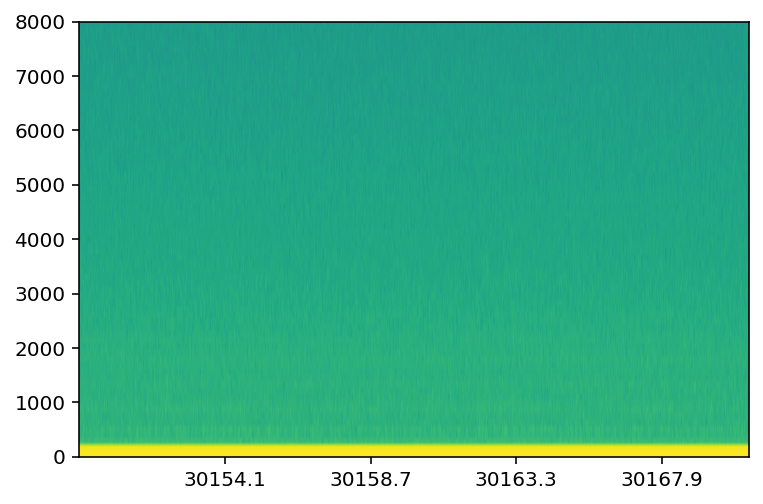

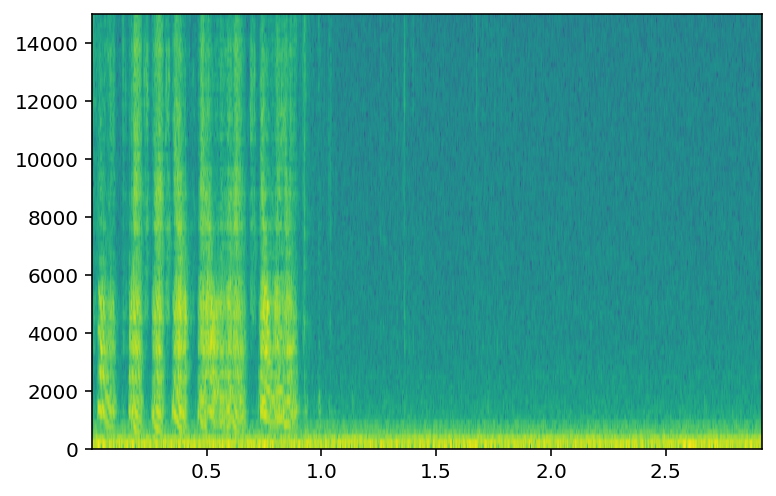

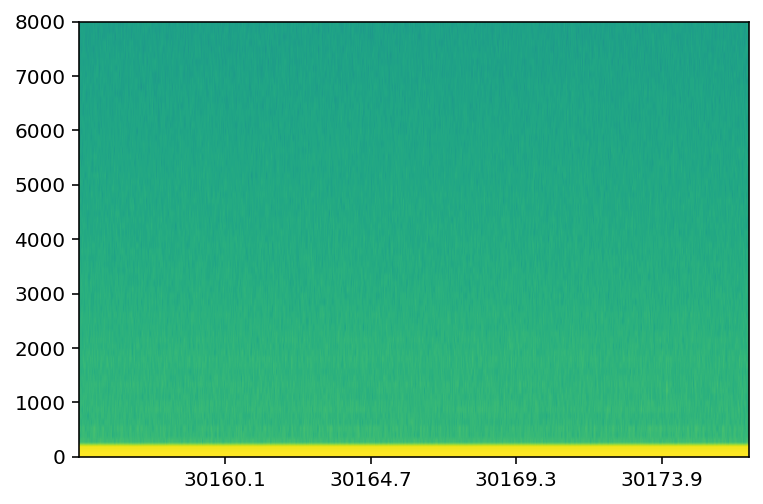

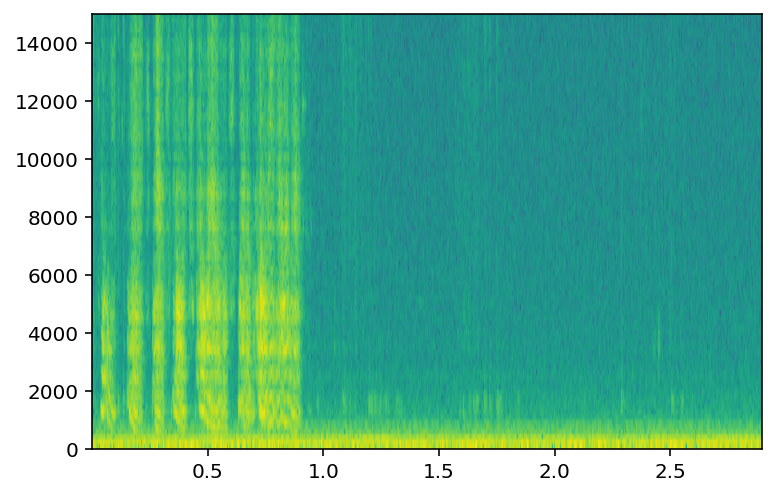

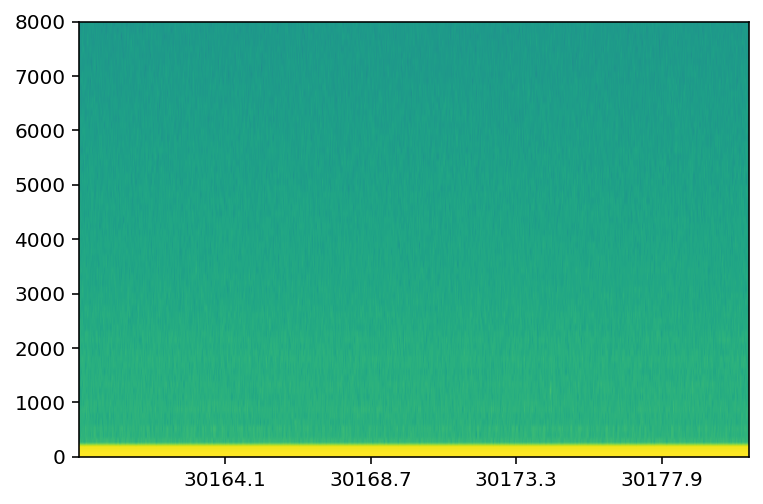

In [210]:
for i in range(4): # len(wav_df)
    # Each column in each row to a tuple that we unpack
    wav_file, tr0, tr1 = wav_df.loc[i,:]
    
    # Get wav file numpy recording object
    wav_recording = get_wav_recording(wav_file)
    
    # Hi fi mic
    sw.plot_spectrogram(wav_recording, channel=0, freqrange=[0,15000])

    # Lo fi mic 
    if 'Or179' in wav_file:
        mic_recording = Or179_recording
        mic_channel = 32
    elif 'Or177' in wav_file:
        mic_recording = Or177_recording
        mic_channel = 33
        
    print(tr0, tr1)
    
    sw.plot_spectrogram(
        mic_recording,
        mic_channel,
        trange=[tr0-10, tr1+10],
        freqrange=[0,8000],
    )
    

Dang, it didn't work. Hard luck. Maybe it's aligned anyway?

In [ ]:
def explore_1(wav_path):

    # Plot wav
#     sw.plot_spectrogram(wav_recordings[1], channel=0, freqrange=[0,15000], trange=[0,3.5])

    # Make axes
    fig, axes=plt.subplots(2,1,figsize=[8,8])
    
    # Plot microphone spectrogram
    sw.plot_spectrogram(mic_recording, 16, trange=trange, freqrange=[0,8000], ax=axes[0])
    axes[0].set_ylabel('Hz')
    
    # Plot microphone 
    sw.plot_timeseries(recording, [*range(1,8)], trange=trange, ax=axes[1])
    for line in axes[1].lines:
        line.set_linewidth(0.5)
        
    axes[1].set_ylabel('$\mu V$')
    
    # Remove all ticks
    for ax in axes:
        ax.axis('off')

C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self._trange[0], self._trange[1], l_xticks))
C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self._trange[0], self._trange[1], l_xticks))
C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self._trange[0], self._trange[1], l_xticks))
C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self.

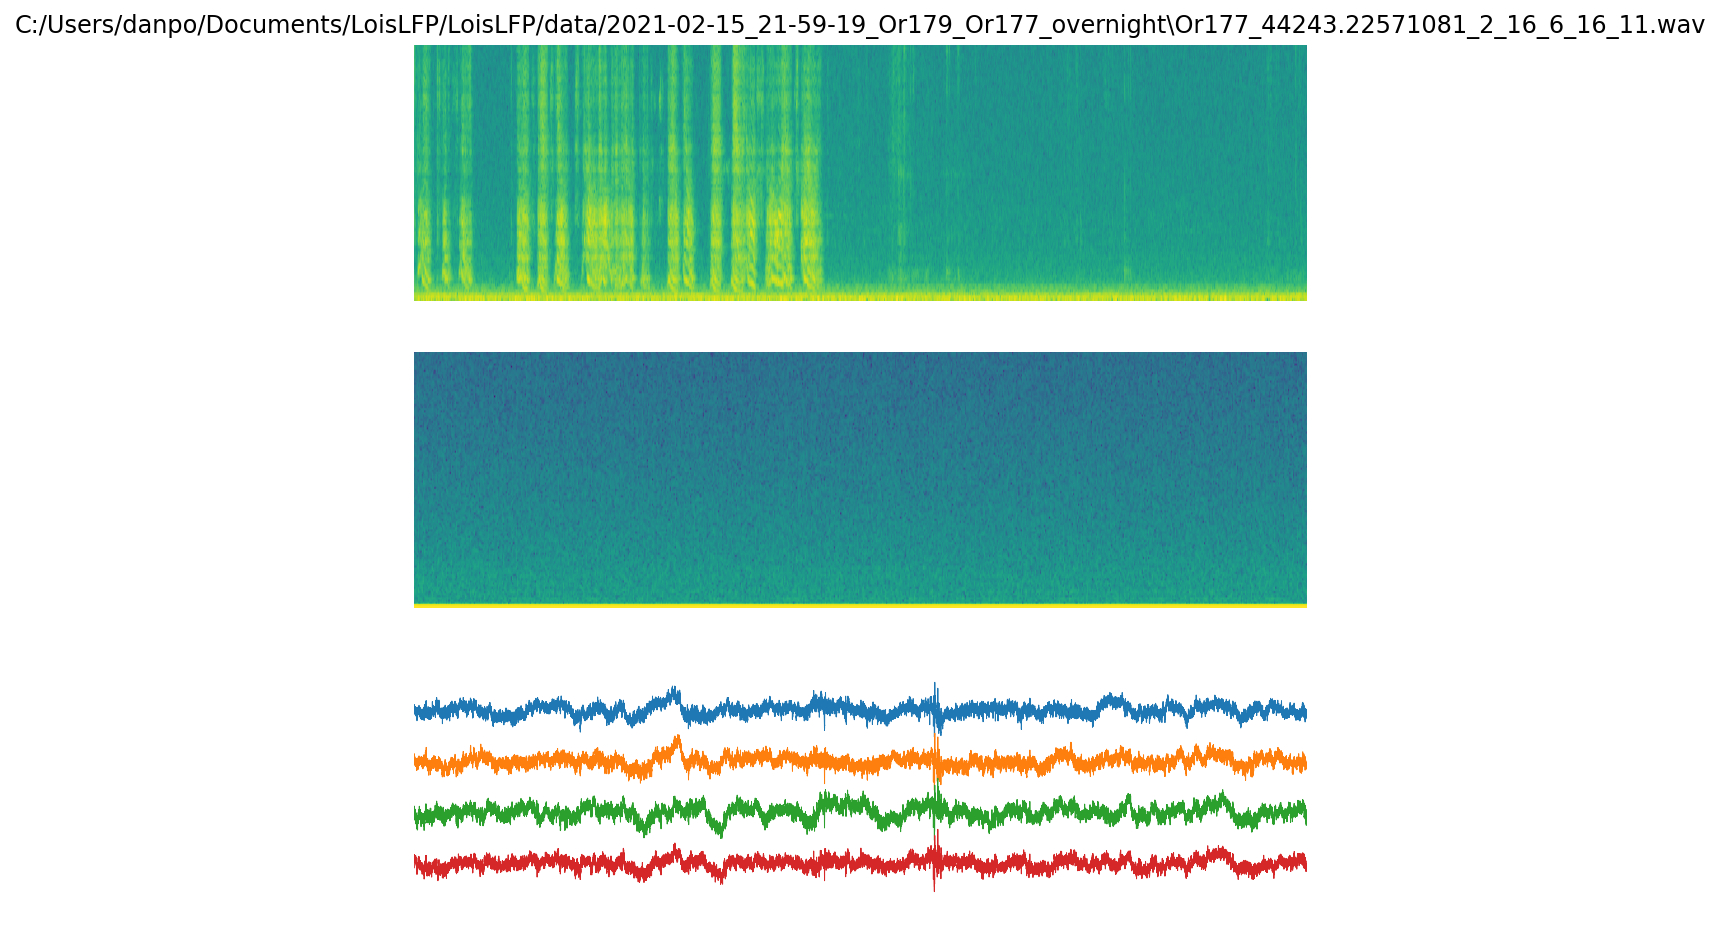

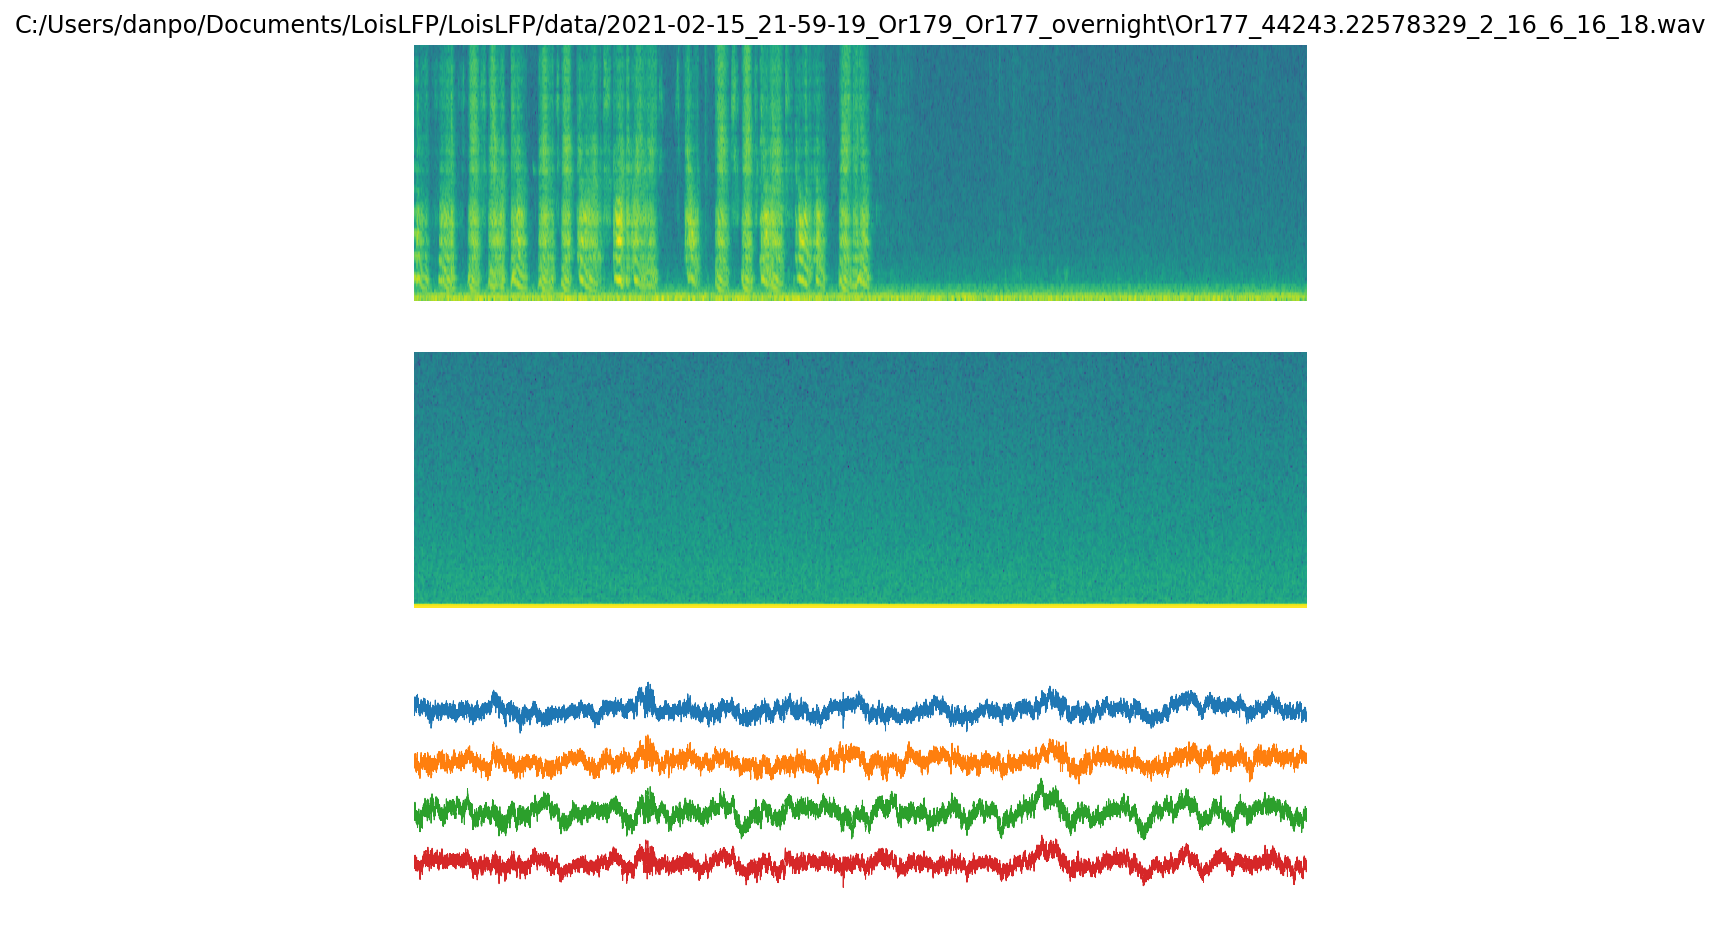

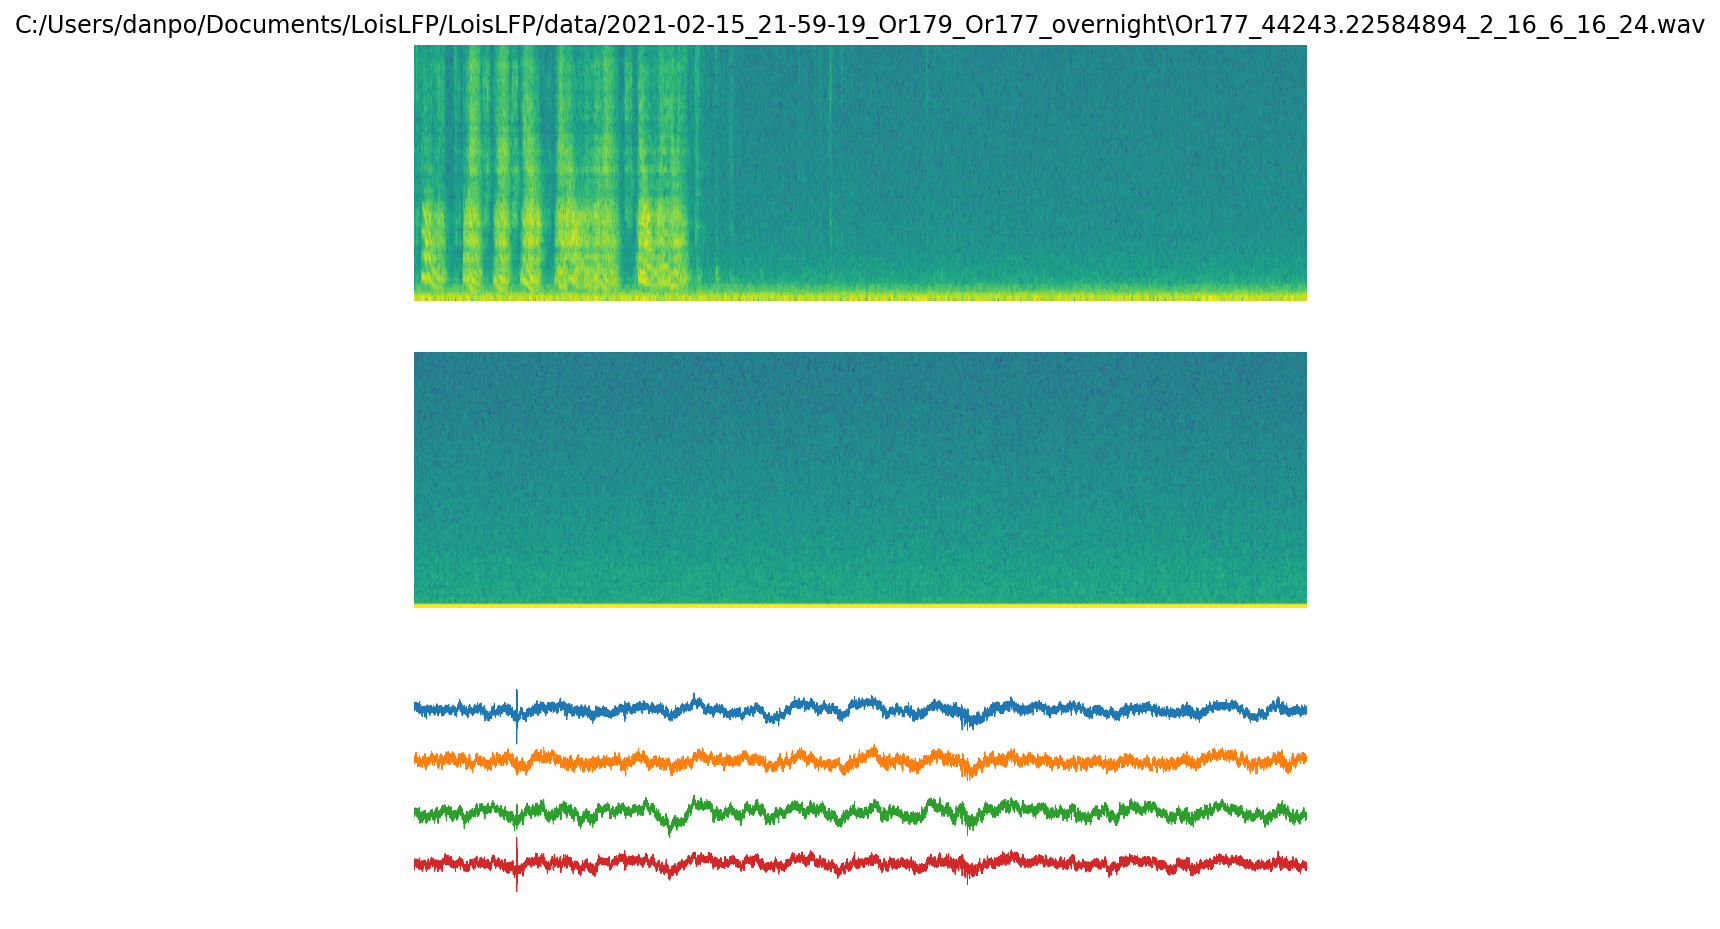

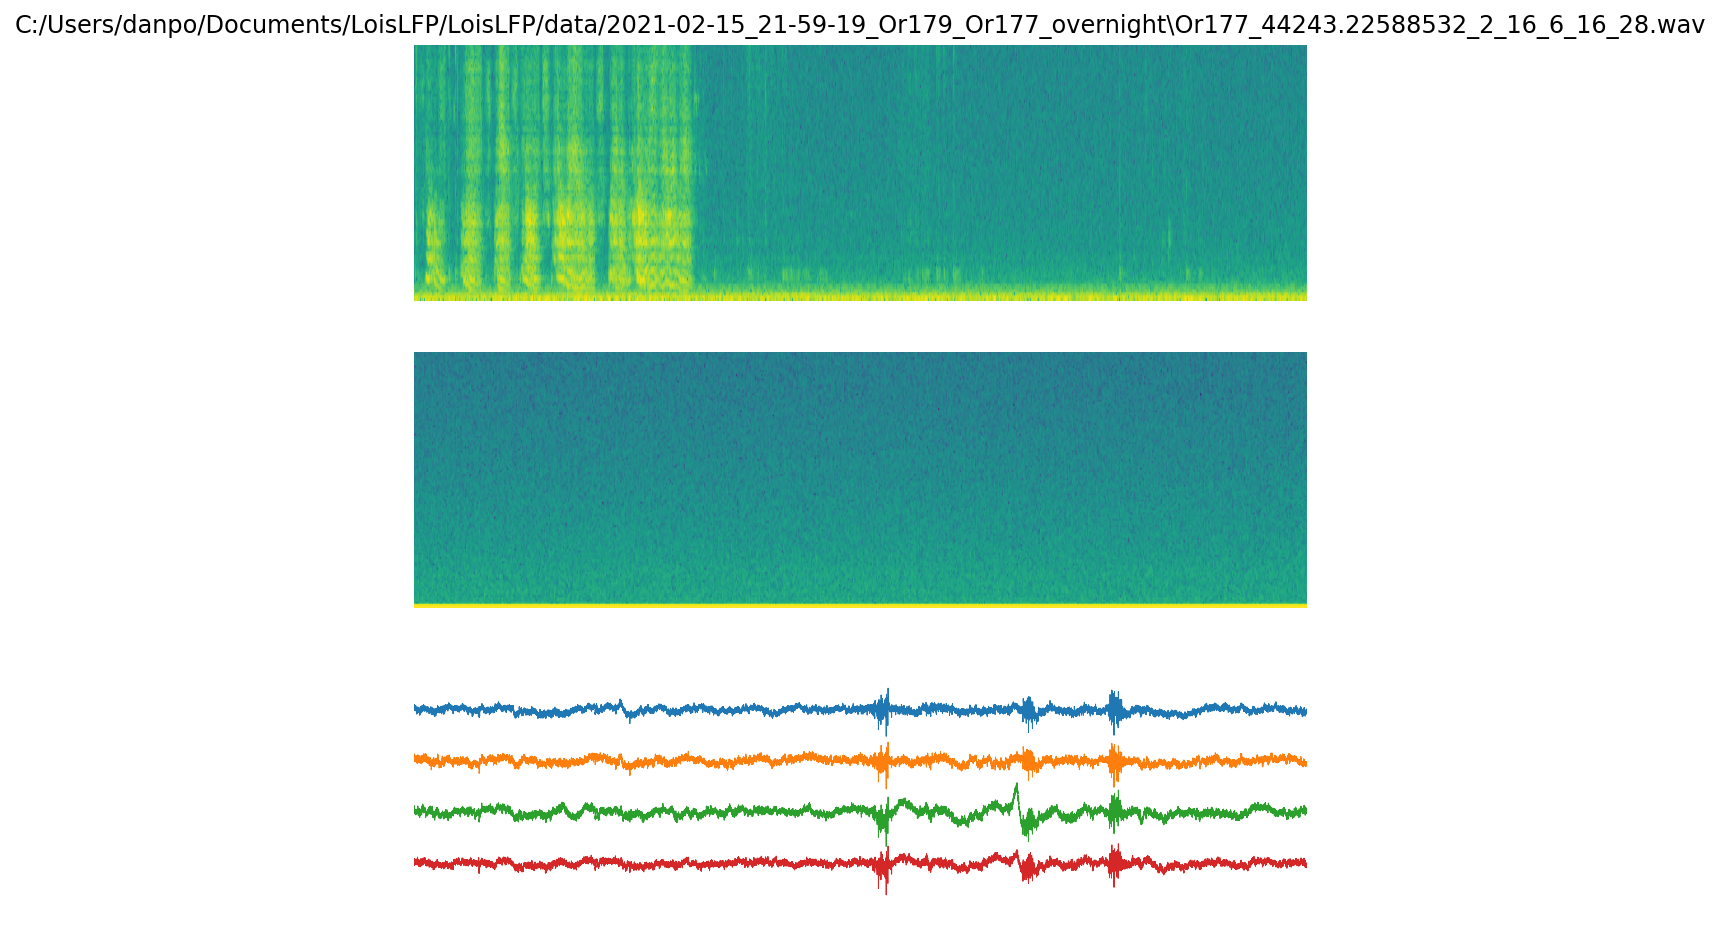

In [217]:
for i in range(4): # len(wav_df)
    fig, axes=plt.subplots(3,1,figsize=[8,8])
    
    # Each column in each row to a tuple that we unpack
    wav_file, tr0, tr1 = wav_df.loc[i,:]
    
    # Get wav file numpy recording object
    wav_recording = get_wav_recording(wav_file)
    
    # Lo fi mic 
    if 'Or179' in wav_file:
        mic_recording = Or179_recording
        mic_channel = 32
    elif 'Or177' in wav_file:
        mic_recording = Or177_recording
        mic_channel = 33
        
    # Hi fi mic
    sw.plot_spectrogram(wav_recording, channel=0, freqrange=[0,15000], ax=axes[0])
    
    axes[0].set_title(wav_file)
    
    # Lo fi mic
    sw.plot_spectrogram(
        mic_recording,
        mic_channel,
        trange=[tr0, tr1],
        freqrange=[0,14000],
        ax=axes[1]
    )
    
    sw.plot_timeseries(
        mic_recording,
        channel_ids=[0,2,4,6],
        trange=[tr0, tr1],
        ax=axes[2]
    )
    
    # Clean lines
    for line in axes[2].lines:
        line.set_linewidth(0.5)
    
    # Remove all ticks
    for ax in axes:
        ax.axis('off')